# Data extracted from Skytrax
# https://www.airlinequality.com
# https://www.airlinequality.com/airline-reviews/british-airways

# Import libraries

In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

import re
from nltk.corpus import stopwords
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Data extraction

In [ ]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [ ]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,Not Verified | Check in was smooth enough. Bo...
1,✅ Trip Verified | Although transferring to thi...
2,✅ Trip Verified | We are extremely grateful ...
3,✅ Trip Verified | I had an appalling experie...
4,"Not Verified | Good points, the cabin crew, t..."


In [ ]:
#df.to_csv("data/BA_reviews.csv")

# Data exploration

In [ ]:
df

,reviews
0,Not Verified | Check in was smooth enough. Bo...
1,✅ Trip Verified | Although transferring to thi...
2,✅ Trip Verified | We are extremely grateful ...
3,✅ Trip Verified | I had an appalling experie...
4,"Not Verified | Good points, the cabin crew, t..."
...,...
995,Not Verified | Chicago to Zurich via London. D...
996,✅ Trip Verified | Glasgow to London. Smooth fl...
997,✅ Trip Verified | Having booked this flight a ...
998,✅ Trip Verified | I wouldn't even rate them 1...


In [ ]:
df.sample(6)

,reviews
122,✅ Trip Verified | This is a route I fly regula...
733,Not Verified | Currently dreading my flight w...
320,Not Verified | Failed at all basic travel fund...
206,✅ Trip Verified | The plane was extremely dir...
789,✅ Trip Verified | My return flight from Antig...
444,✅ Trip Verified | Plane was over an hour late ...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


# Data cleansing

In [ ]:
stop_words = set(stopwords.words('english'))

def clean_text(text):

    text = re.sub(r'(✅\s*)?trip\s+verified', '', text, flags=re.IGNORECASE)
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = nltk.word_tokenize(text)

    cleaned = [word for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(cleaned)


df['cleaned_reviews'] = df['reviews'].apply(clean_text)
print(df[['reviews', 'cleaned_reviews']].head())


                                             reviews  \
0  Not Verified |  Check in was smooth enough. Bo...   
1  ✅ Trip Verified | Although transferring to thi...   
2  ✅ Trip Verified |   We are extremely grateful ...   
3  ✅ Trip Verified |   I had an appalling experie...   
4  Not Verified |  Good points, the cabin crew, t...   

                                     cleaned_reviews  
0  verified check smooth enough boarding chaotic ...  
1  although transferring flight heathrow budapest...  
2  extremely grateful crew flight cape town heath...  
3  appalling experience british airways started t...  
4  verified good points cabin crew helpful profes...  


# Data analysis

In [ ]:
from collections import Counter

all_words = ' '.join(df['cleaned_reviews']).split()
word_freq = Counter(all_words)
print(word_freq.most_common(20))


[('flight', 1983), ('service', 731), ('time', 543), ('crew', 457), ('british', 447), ('seat', 443), ('london', 437), ('food', 436), ('class', 427), ('one', 427), ('airways', 427), ('good', 426), ('would', 406), ('business', 402), ('get', 390), ('staff', 385), ('seats', 378), ('hours', 373), ('cabin', 371), ('back', 312)]


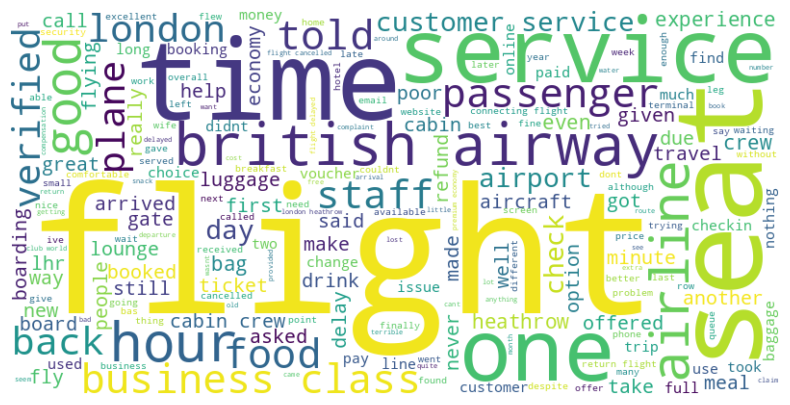

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(df['cleaned_reviews'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

df['sentiment_scores'] = df['cleaned_reviews'].apply(lambda x: sia.polarity_scores(x))
df['compound'] = df['sentiment_scores'].apply(lambda score_dict: score_dict['compound'])
df['sentiment_label'] = df['compound'].apply(lambda c: 'positive' if c >= 0.05 else ('negative' if c <= -0.05 else 'neutral'))

df[['cleaned_reviews', 'compound', 'sentiment_label']].head()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,cleaned_reviews,compound,sentiment_label
0,verified check smooth enough boarding chaotic ...,-0.4404,negative
1,although transferring flight heathrow budapest...,0.9693,positive
2,extremely grateful crew flight cape town heath...,0.8016,positive
3,appalling experience british airways started t...,-0.9802,negative
4,verified good points cabin crew helpful profes...,0.9337,positive


sentiment_label
positive    533
negative    447
neutral      20
Name: count, dtype: int64


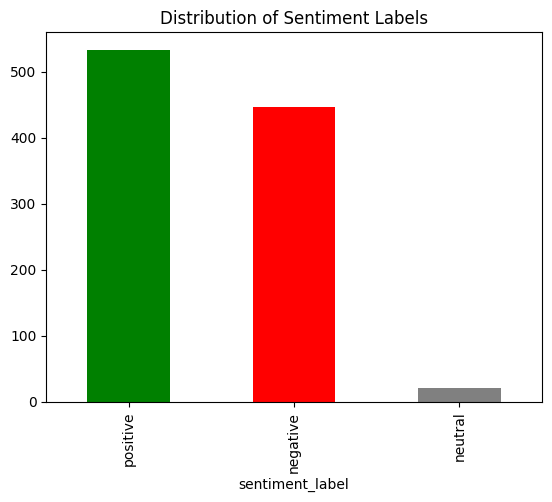

In [ ]:
sentiment_counts = df['sentiment_label'].value_counts()
print(sentiment_counts)

sentiment_counts.plot(kind='bar', color=['green', 'red', 'grey'])
plt.title('Distribution of Sentiment Labels')
plt.show()


In [ ]:
positive_words = ' '.join(df[df['sentiment_label'] == 'positive']['cleaned_reviews']).split()
positive_freq = Counter(positive_words)
print(positive_freq.most_common(20))


[('flight', 994), ('service', 403), ('good', 369), ('time', 339), ('crew', 330), ('food', 305), ('cabin', 263), ('class', 262), ('seat', 256), ('business', 250), ('seats', 226), ('one', 220), ('london', 214), ('would', 213), ('staff', 212), ('british', 208), ('get', 200), ('airways', 197), ('first', 185), ('club', 168)]


In [ ]:
negative_words = ' '.join(df[df['sentiment_label'] == 'negative']['cleaned_reviews']).split()
negative_freq = Counter(negative_words)
print(negative_freq.most_common(20))


[('flight', 954), ('service', 312), ('british', 231), ('hours', 227), ('airways', 223), ('london', 216), ('one', 203), ('time', 201), ('customer', 190), ('would', 189), ('get', 182), ('seat', 180), ('airline', 174), ('told', 174), ('cancelled', 169), ('staff', 166), ('class', 158), ('flights', 154), ('even', 150), ('back', 149)]


In [ ]:
df['review_length'] = df['cleaned_reviews'].apply(lambda x: len(x.split()))
print(df['review_length'].describe())


count    1000.000000
mean       76.412000
std        52.960108
min         9.000000
25%        39.000000
50%        61.000000
75%        96.250000
max       306.000000
Name: review_length, dtype: float64


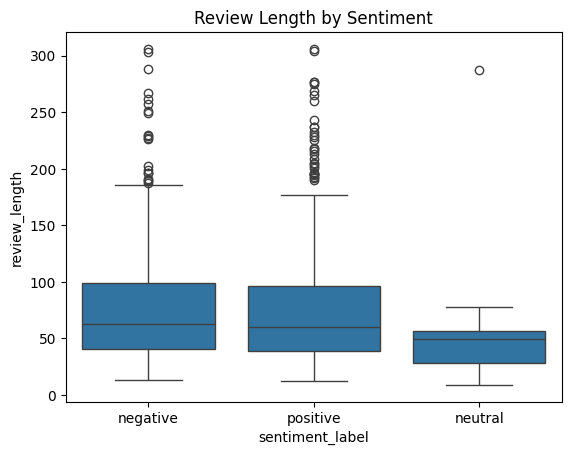

In [ ]:
import seaborn as sns

sns.boxplot(x='sentiment_label', y='review_length', data=df)
plt.title('Review Length by Sentiment')
plt.show()


In [ ]:
keywords = ['delay', 'crew', 'service', 'flight', 'comfort']
for word in keywords:
    count = sum(df['cleaned_reviews'].str.contains(word))
    print(f"'{word}' appeared in {count} reviews")


'delay' appeared in 220 reviews
'crew' appeared in 318 reviews
'service' appeared in 498 reviews
'flight' appeared in 815 reviews
'comfort' appeared in 172 reviews


In [ ]:
negative_keywords = ['delay', 'cancelled', 'problem', 'complain', 'bad']

def extract_negative_sentences(text):
    sentences = nltk.sent_tokenize(text)
    neg_sents = [sent for sent in sentences if any(word in sent.lower() for word in negative_keywords)]
    return neg_sents

df['negative_sentences'] = df['reviews'].apply(extract_negative_sentences)
print(df[['reviews', 'negative_sentences']].head())


                                             reviews negative_sentences
0  Not Verified |  Check in was smooth enough. Bo...                 []
1  ✅ Trip Verified | Although transferring to thi...                 []
2  ✅ Trip Verified |   We are extremely grateful ...                 []
3  ✅ Trip Verified |   I had an appalling experie...                 []
4  Not Verified |  Good points, the cabin crew, t...                 []


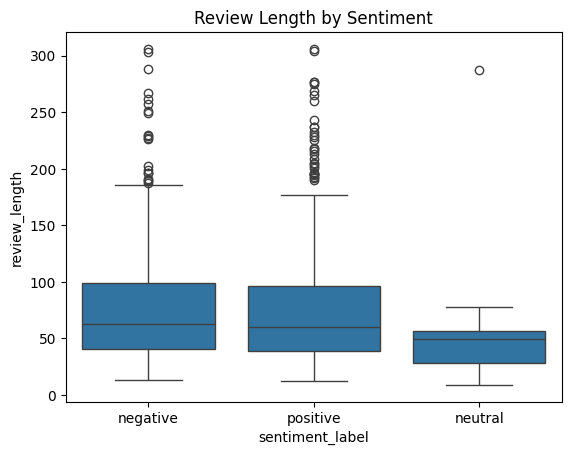

In [ ]:
sns.boxplot(x='sentiment_label', y='review_length', data=df)
plt.title('Review Length by Sentiment')
plt.show()


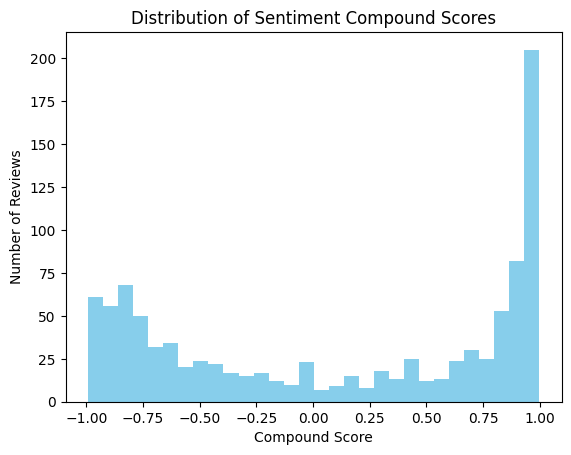

In [ ]:
plt.hist(df['compound'], bins=30, color='skyblue')
plt.title('Distribution of Sentiment Compound Scores')
plt.xlabel('Compound Score')
plt.ylabel('Number of Reviews')
plt.show()


In [ ]:
for index, row in df[df['sentiment_label'] == 'negative'].head(5).iterrows():
    print(f"Review {index} negative sentences:")
    for sent in row['negative_sentences']:
        print(f"- {sent}")
    print()


Review 0 negative sentences:

Review 3 negative sentences:

Review 7 negative sentences:

Review 11 negative sentences:

Review 12 negative sentences:



In [ ]:

neg_sents = df['negative_sentences'].explode().dropna()
neg_words = ' '.join(neg_sents).split()
neg_freq = Counter(neg_words)
print(neg_freq.most_common(20))


[('the', 735), ('to', 597), ('and', 469), ('was', 408), ('flight', 374), ('a', 335), ('I', 266), ('of', 222), ('on', 189), ('for', 180), ('in', 179), ('cancelled', 171), ('that', 164), ('my', 161), ('BA', 140), ('delayed', 137), ('we', 135), ('with', 132), ('at', 128), ('had', 126)]


In [ ]:
verified_count = df['reviews'].str.contains('✅ Trip Verified', case=False).sum()
print(f'Number of reviews containing "✅ Trip Verified": {verified_count}')


Number of reviews containing "✅ Trip Verified": 740


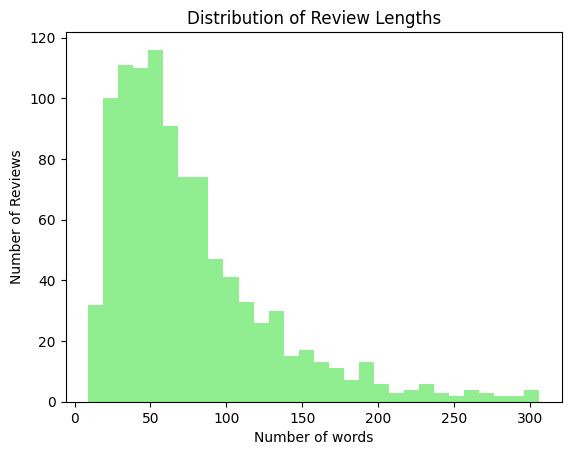

In [ ]:
plt.hist(df['review_length'], bins=30, color='lightgreen')
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of words')
plt.ylabel('Number of Reviews')
plt.show()


In [ ]:
neutral_samples = df[df['sentiment_label'] == 'neutral']['cleaned_reviews'].head(5)
print(neutral_samples.to_list())


['flight joke four people business class including companion service outrageous crew busy flirting captain going day instead paying attention cabin', 'booked loganair dont representatives manchester airport loganair cancelled flight someone marked flight delayed minutes ive spent days chasing bas complaints department best totally ineffective wont put people dealing claim apparently dont facility wont phone loganair wont look manchester airports historic flight website confirm cancellation wont put supervisor fact little apologise little', 'transit visa required partner transit via london iceland buy separate ticket via another airline reach iceland emailed british airways telling wont using return ticket requested partial refund days later received email customer service need contact one service centres via provided link replied say link goes page various british landline phone numbers call explained overseas practical via international calls replied say contacting service centres air

In [ ]:
percentages = df['sentiment_label'].value_counts(normalize=True) * 100
print(percentages)


sentiment_label
positive    53.3
negative    44.7
neutral      2.0
Name: proportion, dtype: float64


In [ ]:
long_reviews = df[df['review_length'] > df['review_length'].median()]['cleaned_reviews']
short_reviews = df[df['review_length'] <= df['review_length'].median()]['cleaned_reviews']

long_words = ' '.join(long_reviews).split()
short_words = ' '.join(short_reviews).split()

long_freq = Counter(long_words)
short_freq = Counter(short_words)

print("Common words in long reviews:", long_freq.most_common(10))
print("Common words in short reviews:", short_freq.most_common(10))


Common words in long reviews: [('flight', 1352), ('service', 487), ('time', 370), ('one', 329), ('would', 322), ('british', 312), ('class', 311), ('seat', 306), ('business', 306), ('get', 304)]
Common words in short reviews: [('flight', 631), ('service', 244), ('food', 176), ('time', 173), ('london', 164), ('good', 162), ('crew', 155), ('seat', 137), ('british', 135), ('airways', 134)]


In [ ]:
positive_reviews = df[df['sentiment_label'] == 'positive']['cleaned_reviews']

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(positive_reviews)

lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X)

words = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"\n🔷 Topic {idx+1}:")
    print([words[i] for i in topic.argsort()[-10:]])



🔷 Topic 1:
['business', 'seat', 'class', 'cabin', 'time', 'service', 'food', 'crew', 'good', 'flight']

🔷 Topic 2:
['booked', 'hours', 'airport', 'london', 'told', 'customer', 'service', 'airways', 'british', 'flight']

🔷 Topic 3:
['luggage', 'like', 'staff', 'service', 'london', 'cabin', 'crew', 'time', 'food', 'flight']


In [ ]:
negative_reviews = df[df['sentiment_label'] == 'negative']['cleaned_reviews']

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(negative_reviews)

lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X)

words = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"\n🔴 Topic {idx+1}:")
    print([words[i] for i in topic.argsort()[-10:]])



🔴 Topic 1:
['british', 'customer', 'cabin', 'crew', 'business', 'class', 'seats', 'service', 'flight', 'seat']

🔴 Topic 2:
['time', 'customer', 'told', 'london', 'cancelled', 'service', 'airways', 'british', 'hours', 'flight']

🔴 Topic 3:
['cabin', 'boarding', 'economy', 'seat', 'staff', 'service', 'business', 'food', 'class', 'flight']


In [ ]:
negative_words = ' '.join(df[df['sentiment_label'] == 'negative']['cleaned_reviews']).split()
filtered_negative = [word for word in negative_words if word.lower() not in stop_words]

negative_freq = Counter(filtered_negative)
print("Top words in negative reviews:")
print(negative_freq.most_common(20))


Top words in negative reviews:
[('flight', 954), ('service', 312), ('british', 231), ('hours', 227), ('airways', 223), ('london', 216), ('one', 203), ('time', 201), ('customer', 190), ('would', 189), ('get', 182), ('seat', 180), ('airline', 174), ('told', 174), ('cancelled', 169), ('staff', 166), ('class', 158), ('flights', 154), ('even', 150), ('back', 149)]


In [ ]:
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
X = vectorizer.fit_transform(df[df['sentiment_label'] == 'negative']['cleaned_reviews'])

sum_words = X.sum(axis=0)
bigrams_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
bigrams_freq = sorted(bigrams_freq, key=lambda x: x[1], reverse=True)

print(" Most common bigrams in negative reviews:")
for bigram, freq in bigrams_freq[:10]:
    print(f"{bigram}: {freq}")


 Most common bigrams in negative reviews:
british airways: 216
customer service: 137
business class: 120
connecting flight: 67
flight cancelled: 55
flight delayed: 52
cabin crew: 49
return flight: 42
cancelled flight: 33
flight london: 32


In [ ]:
texts = df[df['sentiment_label'] == 'negative']['cleaned_reviews']

tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(texts)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

order = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()
for i in range(3):
    print(f"\n🔻 Cluster {i + 1}")
    print([terms[ind] for ind in order[i][:10]])



🔻 Cluster 1
['seat', 'class', 'business', 'flight', 'seats', 'food', 'service', 'crew', 'airline', 'economy']

🔻 Cluster 2
['flight', 'cancelled', 'british', 'customer', 'airways', 'hours', 'service', 'told', 'london', 'luggage']

🔻 Cluster 3
['flight', 'water', 'time', 'board', 'plane', 'offered', 'small', 'food', 'hour', 'passengers']


In [ ]:
filtered_df = df[df['sentiment_label'].isin(['positive', 'negative'])].copy()


vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(filtered_df['cleaned_reviews'])


n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
topic_distributions = lda.fit_transform(X)

filtered_df['dominant_topic'] = topic_distributions.argmax(axis=1)


topic_sentiment_counts = pd.crosstab(filtered_df['dominant_topic'], filtered_df['sentiment_label'], normalize='index') * 100


words = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"\n Topic {idx} Top Words:")
    print(", ".join([words[i] for i in topic.argsort()[-10:]]))


print("\n Sentiment distribution per topic (%):")
print(topic_sentiment_counts.round(2))



 Topic 0 Top Words:
club, seat, service, cabin, business, food, class, crew, good, flight

 Topic 1 Top Words:
london, cancelled, airport, hours, airways, told, customer, british, service, flight

 Topic 2 Top Words:
customer, class, business, staff, airways, british, airline, service, flight, luggage

 Topic 3 Top Words:
return, crew, flights, british, airways, service, london, food, time, flight

 Topic 4 Top Words:
check, fly, airline, london, airways, british, service, seats, flight, seat

 Sentiment distribution per topic (%):
sentiment_label  negative  positive
dominant_topic                     
0                   22.92     77.08
1                   67.52     32.48
2                   59.26     40.74
3                   30.60     69.40
4                   61.07     38.93


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   reviews             1000 non-null   object 
 1   cleaned_reviews     1000 non-null   object 
 2   sentiment_scores    1000 non-null   object 
 3   compound            1000 non-null   float64
 4   sentiment_label     1000 non-null   object 
 5   review_length       1000 non-null   int64  
 6   negative_sentences  1000 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 54.8+ KB


In [ ]:
df.sample(3)

,reviews,cleaned_reviews,sentiment_scores,compound,sentiment_label,review_length,negative_sentences
528,Not Verified | I’ve generally been a loyal Go...,verified ive generally loyal gold status flyer...,"{'neg': 0.108, 'neu': 0.689, 'pos': 0.203, 'co...",0.9196,positive,86,[We should have departed at 10:20 but after co...
750,✅ Trip Verified | We have flown with BA for m...,flown many years never alternative booked paid...,"{'neg': 0.165, 'neu': 0.782, 'pos': 0.053, 'co...",-0.7906,negative,63,[We were delayed on the ground for 30 minutes ...
627,✅ Trip Verified | This flight was not affecte...,flight affected recent problems quite impresse...,"{'neg': 0.062, 'neu': 0.574, 'pos': 0.364, 'co...",0.9643,positive,51,[✅ Trip Verified | This flight was not affect...
